In [1]:
%config Completer.use_jedi = False

In [2]:
from scipy import stats
from scipy.stats import entropy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
np.set_printoptions(suppress=True)

# LOADING DATA

In [4]:
DIRTY_GROUP_FEATURIZED_PATH = "./Datasets/Featurized/BankChurners/DirtyGroup"

In [5]:
dataset = pickle.load(open(f"{DIRTY_GROUP_FEATURIZED_PATH}/DirtyGroup.pickle", "rb"))

# META MODEL INTERFACE

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import clone as clone_estimator
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from itertools import groupby

In [7]:
class MetaNoveltyModel:
    def __init__(self, base_clr, base_scaler):
        self.base_clr = base_clr
        self.base_scaler = base_scaler
        self.estimators = dict()
        self.scalers = dict()
    
    def fit(self, X, z):
        sorted_by_column = sorted(zip(X, z), key=lambda x: x[-1])
        
        for (z_val, X_z) in groupby(sorted_by_column, key=lambda x: x[-1]):
            X_, _ = zip(*X_z)
            estimator = clone_estimator(self.base_clr, safe=True)
            scaler = clone_estimator(self.base_scaler, safe=True)
            x_ = scaler.fit_transform(X_)
            estimator.fit(x_)
            self.estimators[z_val] = estimator
            self.scalers[z_val] = scaler
    
    def __predict(self, column, x):
        check_is_fitted(self.scalers[column])
        check_is_fitted(self.estimators[column])
        
        return self.estimators[column].predict(
            self.scalers[column].transform(
                np.atleast_2d(x)
            )
        )
    
    def __decision_function(self, column, x):
        check_is_fitted(self.scalers[column])
        check_is_fitted(self.estimators[column])
        
        if(hasattr(self.estimators[column], 'decision_function')):
            return self.estimators[column].decision_function(
                self.scalers[column].transform(
                    np.atleast_2d(x)
                )
            )
        else:
            raise Exception(f"estimator for {column} has no decision_function")
            
    def __apply_function(self, X, z, func):
        i = list(range(len(z)))
        sorted_by_column = sorted(zip(X, i, z), key=lambda x: x[-1])
        
        pred = np.zeros((len(z)))
        
        for (z_val, X_z) in groupby(sorted_by_column, key=lambda x: x[-1]):
            X_, i_, _ = zip(*X_z)
            pred[list(i_)] = func(z_val, X_)
            
        return np.array(pred)
    
    def predict(self, X, z):
        return self.__apply_function(X, z, self.__predict)
    
    def decision_function(self, X, z):
        return self.__apply_function(X, z, self.__decision_function)

In [8]:
class MetaOutlierModel:
    def __init__(self, base_clr, base_scaler):
        self.base_clr = base_clr
        self.base_scaler = base_scaler
        self.estimators = dict()
        self.scalers = dict()
    
    def __fit_predict(self, column, x):
        return self.estimators[column].fit_predict(
            self.scalers[column].fit_transform(
                np.atleast_2d(x)
            )
        )
    
    def __fit_decision_function(self, column, x):
        x_ = self.scalers[column].fit_transform(np.atleast_2d(x))
        if(hasattr(self.estimators[column], 'decision_function')):
            self.estimators[column].fit(x_)
            return self.estimators[column].decision_function(x_)
        elif isinstance(self.estimators[column], LocalOutlierFactor):
            self.estimators[column].fit_predict(x_)
            return self.estimators[column].negative_outlier_factor_
        else:    
            raise Exception(f"estimator for {column} has no decision_function")
            
    def __fit_apply(self, X, z, func):
        i = list(range(len(z)))
        sorted_by_column = sorted(zip(X, i, z), key=lambda x: x[-1])
        
        pred = np.zeros((len(z)))
        
        for (z_val, X_z) in groupby(sorted_by_column, key=lambda x: x[-1]):
            self.estimators[z_val] = clone_estimator(self.base_clr, safe=True)
            self.scalers[z_val] = clone_estimator(self.base_scaler, safe=True)
            X_, i_, _ = zip(*X_z)
            pred[list(i_)] = func(z_val, X_)
            
        return np.array(pred)
    
    def fit_predict(self, X, z):
        return self.__fit_apply(X, z, self.__fit_predict)
    
    def fit_decision_function(self, X, z):
        return self.__fit_apply(X, z, self.__fit_decision_function)

# TRAIN / INFER NOVELTY DETECTION

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import scipy.stats as ss

In [10]:
X_train = list()
Z_train = list()

for col, features in dataset['train'].items():
    X, z = zip(*[(x[0], col) for x in features])
    X_train += X
    Z_train += list(z)

In [11]:
X_control = list()
Y_control = list()
Z_control = list()

for col, features in dataset['control'].items():
    X, y, z = zip(*[(x[0], x[1], col) for x in features])
    X_control += X
    Y_control += y
    Z_control += list(z)
    
Y_control = np.array(Y_control)

# UNDERSAMPLED EVALUATION

In [12]:
from functools import reduce

In [13]:
algorithms_novelty = {
    'LocalOutlierFactorNovelty': LocalOutlierFactor(novelty=True),
    'OneClassSVM_Linear': OneClassSVM(kernel='linear'),
    'OneClassSVM_RBF': OneClassSVM()
}

algorithms_outlier = {
    'LocalOutlierFactor': LocalOutlierFactor(novelty=False),
    'IsolationForest': IsolationForest()
}

In [14]:
_, counts = np.unique(Y_control, return_counts=True)

NUM_NEGATIVES = counts[0]
NUM_POSITIVES = counts[1]
NUM_ITERATIONS = 10

POSITIVE_LOC = np.argwhere(Y_control == True).squeeze()
NEGATIVE_LOC = np.argwhere(Y_control == False).squeeze()

In [15]:
X_control_negatives = np.array(X_control, dtype='object')[NEGATIVE_LOC].tolist()
Y_control_negatives = np.array(Y_control, dtype='object')[NEGATIVE_LOC].tolist()
Z_control_negatives = np.array(Z_control, dtype='object')[NEGATIVE_LOC].tolist()

In [18]:
results = dict()

for algo_name, algo in algorithms_novelty.items():
    results[algo_name] = {}
    for i in range(NUM_ITERATIONS):
        for positive_share in [0.01, 0.05, 0.1, 0.15, 0.2]:
            num_positives = int(NUM_NEGATIVES / (1 - positive_share) - NUM_NEGATIVES)
            new_positives = np.random.choice(POSITIVE_LOC, num_positives)

            clr = MetaNoveltyModel(algo, StandardScaler())

            clr.fit(X_train, Z_train)

            X_control_positives = np.array(X_control, dtype='object')[new_positives].tolist()
            Y_control_positives = np.array(Y_control, dtype='object')[new_positives].tolist()
            Z_control_positives = np.array(Z_control, dtype='object')[new_positives].tolist()

            X_control_new = X_control_negatives + X_control_positives
            Y_control_new = np.r_[Y_control_negatives, Y_control_positives]
            Z_control_new = Z_control_negatives + Z_control_positives

            preds = clr.predict(X_control_new, Z_control_new)
            anomaly_score = clr.decision_function(X_control_new, Z_control_new)
            
            if str(positive_share) not in results[algo_name]:
                results[algo_name][str(positive_share)] = {}
            
            results[algo_name][str(positive_share)][i] = {
                'true': (Y_control_new).squeeze(),
                'pred': (preds == -1).astype(int).squeeze(),
                'score': (-anomaly_score).squeeze()
            }
            
for algo_name, algo in algorithms_outlier.items():
    results[algo_name] = {}
    for i in range(NUM_ITERATIONS):
        for positive_share in [0.01, 0.05, 0.1, 0.15, 0.2]:
            num_positives = int(NUM_NEGATIVES / (1 - positive_share) - NUM_NEGATIVES)
            new_positives = np.random.choice(POSITIVE_LOC, num_positives)

            clr = MetaOutlierModel(algo, StandardScaler())

            X_control_positives = np.array(X_control, dtype='object')[new_positives].tolist()
            Y_control_positives = np.array(Y_control, dtype='object')[new_positives].tolist()
            Z_control_positives = np.array(Z_control, dtype='object')[new_positives].tolist()

            X_control_new = X_control_negatives + X_control_positives
            Y_control_new = np.r_[Y_control_negatives, Y_control_positives]
            Z_control_new = Z_control_negatives + Z_control_positives

            preds = clr.fit_predict(X_control_new, Z_control_new)
            anomaly_score = clr.fit_decision_function(X_control_new, Z_control_new)
            
            if str(positive_share) not in results[algo_name]:
                results[algo_name][str(positive_share)] = {}
            
            results[algo_name][str(positive_share)][i] = {
                'true': (Y_control_new).squeeze(),
                'pred': (preds == -1).astype(int).squeeze(),
                'score': (-anomaly_score).squeeze()
            }

In [20]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [21]:
metrics = list()
for algo, algo_data in results.items():
    for share, data_iters in algo_data.items():
        precisions = []
        recalls = []
        aucs = []
        
        for i, data in data_iters.items():
            precisions.append(precision_score(data['true'], data['pred']))
            recalls.append(recall_score(data['true'], data['pred']))
            aucs.append(roc_auc_score(data['true'], data['score']))
            
        metrics.append({
            'algorithm': algo,
            'positive_share': float(share),
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'auc': np.mean(aucs)
        })

In [28]:
pd.DataFrame(metrics).sort_values(by=['algorithm', 'positive_share']).reset_index(drop=True)

,algorithm,positive_share,precision,recall,auc
0,IsolationForest,0.01,0.018385,1.000000,0.999982
1,IsolationForest,0.05,0.356378,0.981443,0.990596
2,IsolationForest,0.10,0.854126,0.966990,0.992570
3,IsolationForest,0.15,0.957476,0.931098,0.992453
4,IsolationForest,0.20,0.984667,0.899140,0.986904
5,LocalOutlierFactor,0.01,0.103639,0.961111,0.966132
6,LocalOutlierFactor,0.05,0.362286,0.944330,0.961704
7,LocalOutlierFactor,0.10,0.544185,0.935922,0.955804
8,LocalOutlierFactor,0.15,0.646173,0.937805,0.959190
9,LocalOutlierFactor,0.20,0.718224,0.906452,0.946247


In [45]:
metrics_df = pd.DataFrame(metrics)

metrics_df = metrics_df[metrics_df['algorithm'] != "OneClassSVM_Linear"]
metrics_df.loc[metrics_df['algorithm'] == "OneClassSVM_RBF", "algorithm"] = 'OneClassSVM'

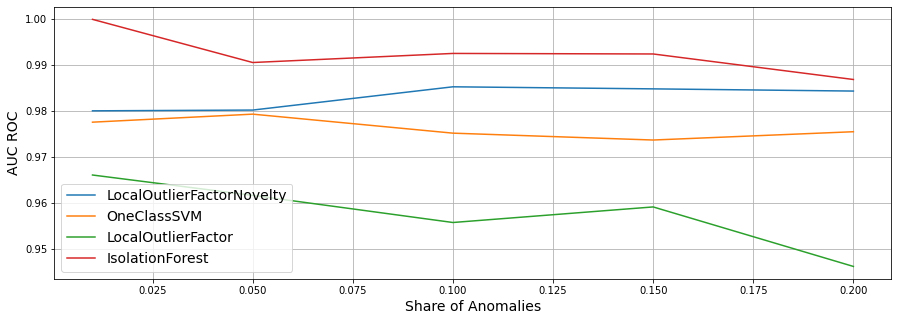

In [64]:
ax = None
for algo_name in metrics_df['algorithm'].unique():
    ax = metrics_df[metrics_df['algorithm']==algo_name][['positive_share', 'auc']]\
        .rename({'auc': algo_name}, axis=1)\
        .plot(x='positive_share', y=algo_name, ax=ax, figsize=(15, 5))
    
    ax.set_xlabel("Share of Anomalies", fontdict={'fontsize':14})
    ax.set_ylabel("AUC ROC", fontdict={'fontsize':14})
    ax.legend(fontsize=14, loc="lower left")
plt.grid()